<a href="https://colab.research.google.com/github/anandsagarthumati9848/Data-driving-cyber-security-research-using-machine-learning-tactics/blob/main/Final_Version_HIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!rm *.txt
! rm *.int

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve, auc, recall_score, precision_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

#**Processing data**

Use the given datasets in our GitHub to load the data

In [12]:
  ## Uncomment each line to load Normal data

# Synthetic sendmail csv_file = ['bounce-1.int', 'bounce.int', 'bounce-2.int', 'plus.int', 'queue.int', 'sendmail.daemon.int', 'sendmail.log.int']; DATA = 'Synthetic Sendmail'; DATA_I='Synthetic_Sendmail'
# LIVE LPR csv_file = ['lpr-normal-10.txt', 'lpr-normal-11.txt']; DATA = 'Live Lpr'; DATA_I='Live-Lpr'
# MIT live lpr csv_file = [ 'mit-lpr-mar.txt']; DATA = 'MIT Live Lpr'; DATA_I='MIT-Lpr'
# LOGIN and PS csv_file = [ 'login-normal.txt', 'ps-normal.txt']; DATA = 'Login and Ps'; DATA_I ="Login-and-Ps"
# INETD csv_file = [ 'inetd-live-unm.int']; DATA = 'Inetd';DATA_I ="Inetd"
# STIDE csv_file = [ 'stide-normal-8k.txt']; DATA = 'Stide';DATA_I ='Stide'
# Live Named  ==> Best result 
csv_file = [ 'normal-named-live-2k.txt']; DATA = 'Live Named';DATA_I ='Live-Named'
# Xlock csv_file = [ 'normal-xlock.txt']; DATA = 'Xlock';DATA_I='Xlock'
# Synthetic Ftp csv_file = [ 'nonself1.int','nonself2.int']; DATA = 'Synthetic Ftp'; DATA_I='Synthetic-Ftp'
# Synthetic lpr csv_file = ['syn.int']; DATA = 'Synthetic Lpr';DATA_I='Synthetic-Lpr'

# Concat a list of files into normal df
list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
df = pd.concat(list_of_dataframes)

# Check number of columns, if > 2, then drop the excess
if len(df.columns) > 2:
    df=df.drop(labels=None, axis=1, columns = [2,3])
df =df.rename(columns= {0:"PID", 1:"Syscall"})

print('Normal data size:', df.shape)


  ## Uncomment each line to load Intrusion data:

# Synthetic sendmail csv_file = ['sm-10763.int', 'fwd-loops-1.int', 'fwd-loops-2.int', 'fwd-loops-3.int', 'fwd-loops-4.int', 'fwd-loops-5.int','sm-280.int', 'sm-314.int','sm-10801.int', 'sm-10814.int']
# LIVE LPR csv_file =['exploit-unm.int']
# MIT live lpr csv_file = [ 'exploit-ai.int']
# LOGIN and PS csv_file = [ 'login-homegrown.int','ps-homegrown.int','login-recovered.int','ps-recovered.int']
# INETD csv_file = [ 'inetd-intrusion.int']
# STIDE csv_file = [ 'stide-intrusion']
# Live Named  ==> Best Result 
csv_file = [ 'exploit-1.int','exploit-2.int']
# Xlock csv_file = [ 'nonself.cs.unm.edu-07.24.97-xlock-2822_new.log.int', 'nonself.cs.unm.edu-07.25.97-xlock-2691_new.log.int']
# Synthetic Ftp csv_file = [ 'exploit2.int']
# Synthetic Lpr csv_file = [ 'exploit-unm.int']

list_of_dataframes = []
for filename in csv_file:
    list_of_dataframes.append(pd.read_csv(filename, sep=' ', header=None, engine='python'))
intrusiondf = pd.concat(list_of_dataframes)

if len(intrusiondf.columns) > 2:
    intrusiondf = intrusiondf.drop(labels=None, axis=1, columns = [2,3])
intrusiondf = intrusiondf.rename(columns= {0:"PID", 1:"Syscall"})

print('intrusion data size: ', intrusiondf.shape)

print('Normal:',df.head(3))
#print(df['PID'].value_counts())
print('Intrusion:',intrusiondf.head())

Normal data size: (2000, 2)
intrusion data size:  (1800, 2)
Normal:    PID  Syscall
0  229       90
1  229      125
2  229      106
Intrusion:     PID  Syscall
0  3289       90
1  3289      125
2  3289      106
3  3289        5
4  3289       90


In [14]:
# This function groups data by PID, so the sequences appear by PID instead of by order, in case it was interrupted by other PID
# It also drops PID column
def group_syscalls_by_pid (df):
  filt = df.groupby(['PID'])
  grouped_df = pd.DataFrame()

  # Get unique PIDs and group syscalls by each PID
  pidList = df['PID'].unique()  
  for p in pidList:
    grouped_df = grouped_df.append(filt.get_group(p), ignore_index=True)

  # Drop PID column to train model on just syscall
  grouped_df.drop(axis = 1, columns='PID', inplace= True)
  return grouped_df

# Group normal df by PID and drop PID column
normal = group_syscalls_by_pid(df)
print('Normal new shape:',normal.shape)

# Do the same thing to intrusion PID
intrusion = group_syscalls_by_pid(intrusiondf)
print('Intrusion new shape:',intrusion.shape)

Normal new shape: (2000, 1)
Intrusion new shape: (1800, 1)


> ## **EDA - Histogram of original data**



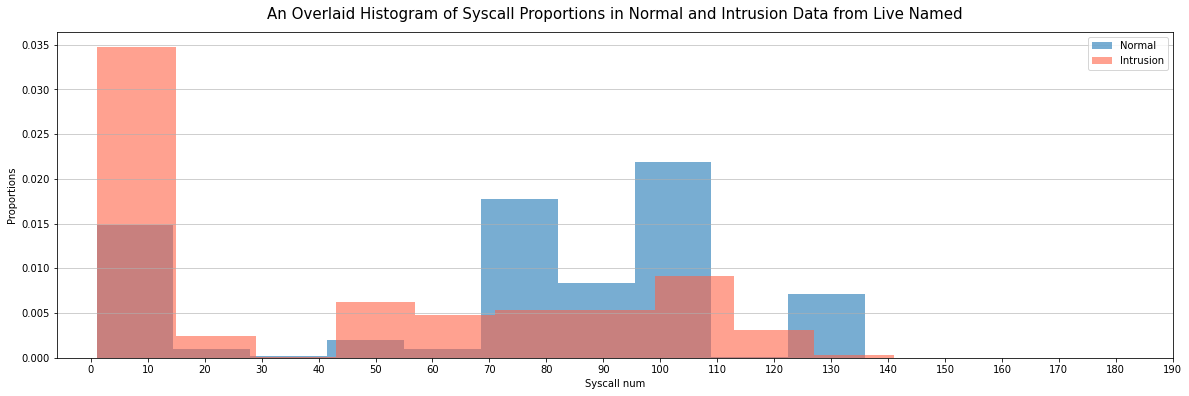

In [15]:
plt.figure(figsize=(20,6))
plt.hist(normal['Syscall'], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion['Syscall'], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(0,200,10))
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)
plt.show()

Start tokenizing system calls into 6-grams

In [17]:
import nltk
nltk.download("popular")

## Tokenizing syscall sequences into n-grams of 6

from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [18]:
## Convert elements in Syscall col into strings of NORMAL sequences
syscall_names = normal.to_string(columns = ['Syscall'], index=False, header = False)
token = word_tokenize(syscall_names)  # Tokenize the string of sequence

# Parse the sequence into length of 6
sequence_list = list(nltk.ngrams(token,6))
normal_sequence = pd.DataFrame(sequence_list)


## Convert elements in Syscall col into strings of INTRUSION sequences
syscall_names = intrusion.to_string(columns = ['Syscall'], index=False, header = False)
token = word_tokenize(syscall_names)  # Tokenize the string of sequence

# Parse the sequence into length of 6
sequence_list = list(nltk.ngrams(token,6)) 
intrusion_sequence = pd.DataFrame(sequence_list)


normal = normal_sequence.astype('int32')
intrusion = intrusion_sequence.astype('int32')

print('Normal shape:', normal.shape)
print('Intrusion shape:', intrusion.shape)

Normal shape: (1995, 6)
Intrusion shape: (1795, 6)


 ## **Data Cleaning**
 Remove rows that exist in both normal and intrusion df



In [19]:
# Clean data, so it only contains unique rows from either dataset
def clean_data(df, intersect_df):
  cleaned_df = df.merge(intersect_df, indicator=True, how='left').loc[lambda x : x['_merge'] != 'both']
  cleaned_df.drop(columns=['_merge'], inplace=True)
  cleaned_df.reset_index(drop=True,inplace=True)
  return cleaned_df

In [20]:
## Get % of duplicates in both datasets

# Convert normal df to set, and intrusion df to set
normal_list = normal.values.tolist()
intrusion_list = intrusion.values.tolist()
normal_set = set(tuple(i) for i in normal_list)
intrusion_set = set(tuple(i) for i in intrusion_list)
print('Set of normal sequences: %d \nSet of intrusion sequences: %d'% (len(normal_set), len(intrusion_set)))

# get their intersection
intersect = normal_set.intersection(intrusion_set)

# Check if there is any intersect 
if len(intersect) != 0:
  intersect_list = [list(x) for x in intersect]
  print('Intersect list len',len(intersect_list))

  # Converting intersect_list to df
  intersect_df = pd.DataFrame(intersect_list)

  # Get number of duplicating rows existing in intrusion df - aka rows that exist in both normal and intrusion
  duplicate_intrusion = pd.merge(intersect_df, intrusion, how="inner", on=[0, 1, 2, 3, 4, 5], validate='one_to_many')

  # Get number of duplicating rows in normal df
  duplicate_normal = pd.merge(intersect_df, normal, how="inner", on=[0, 1, 2, 3, 4, 5], validate='one_to_many')

  print(DATA+' Duplication Percentage: %.2f'%  ((len(duplicate_normal)+len(duplicate_intrusion)) /( len(normal) + len(intrusion) ) *100), '%')
  cleaned_intrusion = clean_data(intrusion, intersect_df)
  cleaned_normal    = clean_data(normal, intersect_df)

  # Updating normal and intrusion dfs if the cleaned set is not empty
  if len(cleaned_normal) != 0:
    normal = cleaned_normal
  # If the cleaned set is empty, don't update it. We don't want an empty dataset.  
  else: 
    print('Empty Cleaned_normal')

  # Repeat the same process to Intrusion cleaned set
  if len(cleaned_intrusion) != 0:
    intrusion = cleaned_intrusion
  else: 
    print('**Empty Cleaned_Intrusion')

# Else, no duplication found
else:
  print(DATA+' No Duplication!')

Set of normal sequences: 313 
Set of intrusion sequences: 431
Intersect list len 256
Live Named Duplication Percentage: 90.18 %


## **Histogram of Processed Data**

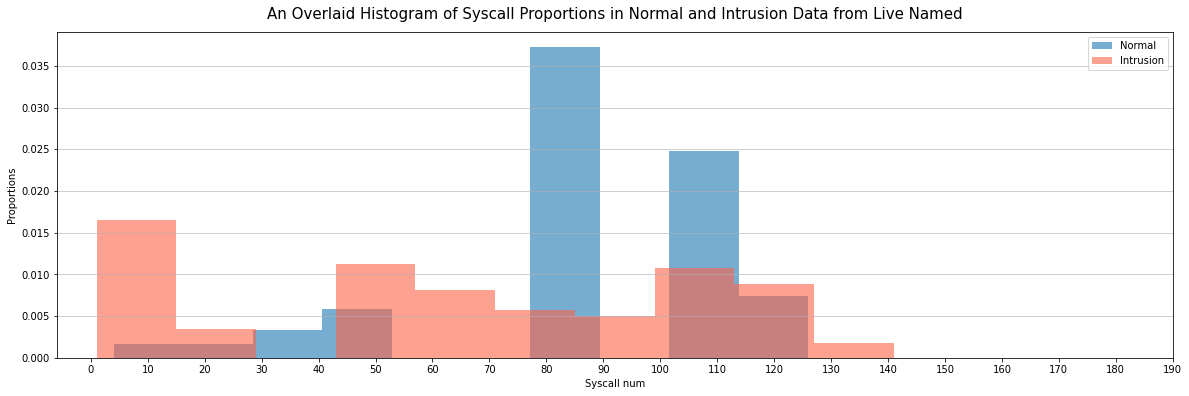

In [21]:
# After Cleaning
plt.figure(figsize=(20,6))
plt.hist(normal[0], label='Normal', alpha=0.6, density=True)
plt.hist(intrusion[0], label='Intrusion', color='tomato', alpha=0.6, density=True)
plt.legend()
plt.ylabel('Proportions')
plt.xlabel('Syscall num')
plt.grid(axis='y', alpha=0.75)
plt.xticks(np.arange(0,200,10))
plt.title('An Overlaid Histogram of Syscall Proportions in Normal and Intrusion Data from ' + DATA,y=1.02, fontsize=15)
plt.show()

**Labeling Sequences**

In [22]:
# Intrusion sequences is labeled 1. Rename columns of the dataframe
intrusion['Label'] = 1
intrusion.rename(columns={0: 'Position1', 1: 'Position2', 2: 'Position3', 3: 'Position4',
                          4: 'Position5', 5: 'Position6'}, inplace=True)

print(intrusion.head(5), '\n')

   Position1  Position2  Position3  Position4  Position5  Position6  Label
0          6         91        102        126         78        104      1
1         91        102        126         78        104         78      1
2        102        126         78        104         78         82      1
3        126         78        104         78         82        102      1
4         78         78         13         20          4         45      1 



In [26]:
# Normal sequences is labeled 0. Rename columns of the dataframe
normal['Label'] = 0
normal.rename(columns={0: 'Position1', 1: 'Position2', 2: 'Position3', 3: 'Position4',
                        4: 'Position5', 5: 'Position6'}, inplace=True)
print(normal.head(5), '\n')

print('Normal len:',len(normal),'\nIntrusion len:', len(intrusion))

   Position1  Position2  Position3  Position4  Position5  Position6  Label
0        102        126         78        102         78        102      0
1        126         78        102         78        102         78      0
2         78        102         78        102         78         45      0
3        102         78        102         78         45        102      0
4         78        102         78         45        102         78      0 

Normal len: 99 
Intrusion len: 273


## **Partition Training and Testing dataset 70/30**

If there is not enough data from either class, bootstrap to generate more data and create a balanced sample

In [28]:
## Bootstrap normal sequences if there is not enough data
normal = normal.sample(n=7000, replace=True)
intrusion = intrusion.sample(n=7000, replace=True)

normal_len = len(normal)
intrusion_len = len(intrusion)
print('normal %d and intrusion len %d' %(normal_len, intrusion_len))

# If both classes have more than 7000 sequences, then get 7000 samples from each class and  split it for training and tetsing
if (normal_len >= 7000) & (intrusion_len >= 7000): 
  samples = normal.sample(n=7000)
  samples = samples.append(intrusion.sample(n=7000), ignore_index = False)
  #print('Get 7k normal sequences and 7k intrusion sequences. Sample len:',len(samples))

# Sample number of records based on the label that has less data:
# if Normal has less data --> sample both normal and intrusion with the amount of normal data; vice versa
else:
  if normal_len < intrusion_len:
    samples = normal.sample(n=normal_len)
    samples = samples.append(intrusion.sample(n=normal_len), ignore_index = False)
  else:
    samples = normal.sample(n= intrusion_len)
    samples = samples.append(intrusion.sample(n= intrusion_len), ignore_index = False)


# Spliting into training and testing
x_train, x_test, y_train, y_test = train_test_split(samples.iloc[:,:6], samples['Label'], test_size = 0.30) 


print('Train sz:',len(x_train), len(y_train))
filt = y_train.loc[y_train == 1]
n_filt = y_train.loc[y_train == 0]
print('Train set: Intrusion vs. Normal cases', len(y_train.iloc[filt] ), len(y_train.iloc[n_filt] ))

print('Test sz:', len(x_test), len(y_test))
filt = y_test.loc[y_test == 1]
n_filt = y_test.loc[y_test == 0]
print('Test set: Intrusion vs. Normal cases', len(y_test.iloc[filt] ), len(y_test.iloc[n_filt] ))

normal 7000 and intrusion len 7000
Train sz: 9800 9800
Train set: Intrusion vs. Normal cases 4961 4839
Test sz: 4200 4200
Test set: Intrusion vs. Normal cases 2039 2161



# **Performance Measures**


1.   Function calc_false_positive: Calculates FPR
2.   Function print_performance: Formats printing performance metrics and ROC curve for each model
3.   Function color_confusion_matrix: prints out a heatmap of confusion matrix in blue color scale






In [33]:
# This function calculate False Positive Rate given a confusion matrix
def calc_false_positive (cmatrix):
  specificity = cmatrix[0,0]/(cmatrix[0,0] + cmatrix[0,1])
  return 1-specificity

# This function prints performance metrics and ROC curve given the model name, true labels and predicted labels
def print_performance( model_name, true_labels, pred_labels):
  # rows are actual, columns are predicted
  cmatrix = confusion_matrix(true_labels, pred_labels)
  fpr = calc_false_positive(cmatrix)

  print('Confusion Matrix: \n',cmatrix)
  print('\nTesting Accuracy: %.2f'% metrics.accuracy_score(true_labels, pred_labels))
  print('Precision:%.2f'%  metrics.precision_score(true_labels, pred_labels))
  print('Recall: %.2f'% metrics.recall_score(true_labels, pred_labels))
  print('False Positive Rate: %.2f'% fpr)
  print('\nClassification report:', classification_report(true_labels, pred_labels), sep='\n')
  print('AUC: %.2f'% roc_auc_score(true_labels, pred_labels))

  false_positive_rate, recall, thresholds = roc_curve(true_labels, pred_labels)
  roc_auc = auc(false_positive_rate, recall)
  plt.figure()
  plt.title( model_name+' ROC Curve on ' + DATA)
  plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.2f' %roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1], [0,1], 'r--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.1])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  #plt.savefig(model_name+'-ROC.jpg')
  plt.show()

# Plot a heatmap of confusion matrix given the model name, a classifier model, testing data and the predicted label
def color_confusion_matrix( model_name, model, x_test, y_test, y_predicted):
  class_names = ['Normal', 'Intrusion']

  fig, ax = plt.subplots(figsize=(6, 6))
  plot_confusion_matrix(model, x_test, y_test, display_labels=class_names, 
                        values_format='d', ax = ax, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix of ' + str(model_name))
  #plt.savefig(model_name+'-CM.jpg')
  plt.show()

  cmatrix = confusion_matrix(y_test, y_predicted)
  print(cmatrix)

# **K-means**

Confusion Matrix: 
 [[2118   43]
 [ 678 1361]]

Testing Accuracy: 0.83
Precision:0.97
Recall: 0.67
False Positive Rate: 0.02

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.98      0.85      2161
           1       0.97      0.67      0.79      2039

    accuracy                           0.83      4200
   macro avg       0.86      0.82      0.82      4200
weighted avg       0.86      0.83      0.82      4200

AUC: 0.82


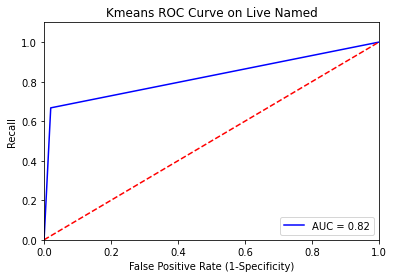

Number of iterations before converging: 8
Train AUC: 0.814 vs Test AUC: 0.824


In [34]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Choose K cluster = 2
kmeans = KMeans(n_clusters=2)
# Fit Kmeans to the training set
kmeans.fit(x_train)


# Recording TPR and FPR to plot TRAINING ROC curves
y_pred = kmeans.predict(x_train)
KM_train = {}
KM_train['fpr'], KM_train['tpr'], thresh = roc_curve(y_train, y_pred)
KM_train['auc'] = roc_auc_score(y_train, y_pred)

## TESTING K-MEANS
y_predicted = kmeans.predict(x_test)

print_performance('Kmeans',y_test, y_predicted)

# Number of iterations before converging
print('Number of iterations before converging:', kmeans.n_iter_)


# Recording TPR and FPR for the TESTING ROC curves
KM_test = {}
KM_test['fpr'], KM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KM_test['auc'] = roc_auc_score(y_test, y_predicted)


print('Train AUC: %.3f vs Test AUC: %.3f' %(KM_train['auc'], KM_test['auc']))

# **Logistic Regression**

Confusion Matrix: 
 [[2038  123]
 [ 491 1548]]

Testing Accuracy: 0.85
Precision:0.93
Recall: 0.76
False Positive Rate: 0.06

Classification report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      2161
           1       0.93      0.76      0.83      2039

    accuracy                           0.85      4200
   macro avg       0.87      0.85      0.85      4200
weighted avg       0.86      0.85      0.85      4200

AUC: 0.85


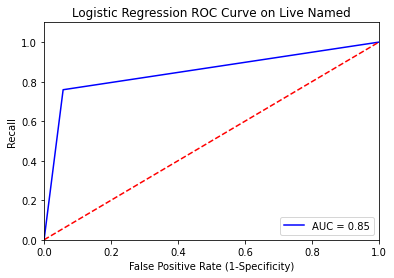

Train AUC: 0.842 vs Test AUC: 0.851


In [36]:
from sklearn.linear_model import LogisticRegression

# Fit the model on the training set
lgModel = LogisticRegression().fit(x_train, y_train)
y_pred = lgModel.predict(x_train)

# Recording TPR and FPR for the TESTING ROC curves
LR_train = {}
LR_train['fpr'], LR_train['tpr'], thresh = roc_curve(y_train, y_pred)
LR_train['auc'] = roc_auc_score(y_train, y_pred)


## TESTING Logistic Regression
y_predicted = lgModel.predict(x_test)

# Evaluating Performance on Testing data
print_performance('Logistic Regression', y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
LR_test = {}
LR_test['fpr'], LR_test['tpr'], thresh = roc_curve(y_test, y_predicted)
LR_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(LR_train['auc'], LR_test['auc']))

# **SVM**

This model uses a Polynomial kernel, and the rest of the parameters are as default







****Polynomial kernel model: 
Confusion Matrix: 
 [[2065   96]
 [ 253 1786]]

Testing Accuracy: 0.92
Precision:0.95
Recall: 0.88
False Positive Rate: 0.04

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2161
           1       0.95      0.88      0.91      2039

    accuracy                           0.92      4200
   macro avg       0.92      0.92      0.92      4200
weighted avg       0.92      0.92      0.92      4200

AUC: 0.92


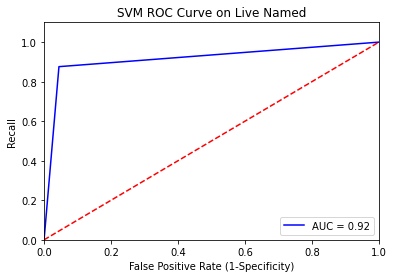

Train AUC: 0.918 vs Test AUC: 0.916


In [40]:
from sklearn import svm

#### Create a SVM classifier using polynomial Kernel
print('\n****Polynomial kernel model: ')
svm_model = svm.SVC(kernel = 'poly')

#Train the  & Get accuracy from training
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_train)

# Recording TPR and FPR for plotting TRAINING ROC curves
SVM_train = {}
SVM_train['fpr'], SVM_train['tpr'], thresh = roc_curve(y_train, y_pred)
SVM_train['auc'] = roc_auc_score(y_train, y_pred)


# Test the model w testing data
y_predicted = svm_model.predict(x_test)

# Evaluate the model 
print_performance('SVM', y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
SVM_test = {}
SVM_test['fpr'], SVM_test['tpr'], thresh = roc_curve(y_test, y_predicted)
SVM_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(SVM_train['auc'], SVM_test['auc']))

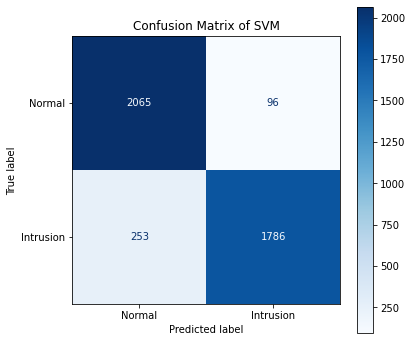

[[2065   96]
 [ 253 1786]]


In [42]:
# Plot a heatmap confusion matrix
color_confusion_matrix('SVM', svm_model, x_test, y_test, y_predicted)

# **Neural Net**

This model contains 3 layers: input layer of 6 nodes, a fully connected layer of 6 nodes and an output layer of 2 nodes

In [43]:
# Scale syscall number to between 0 and 1
# The maximum syscall number in UNM data is 181
max_syscall = 181
x_train_nn = x_train/max_syscall
x_test_nn = x_test/max_syscall

In [44]:
import tensorflow as tf
from tensorflow import keras

nn_model = keras.Sequential([
    keras.layers.Input(shape = (6,)),           # model expect input to be a vector of 6 numbers
    keras.layers.Dense(6, activation = 'relu'), 
    keras.layers.Dense(2, activation = 'sigmoid')
])

nn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model to training set
history = nn_model.fit(x_train_nn, y_train, epochs=10, batch_size=100, verbose=1)  

Epoch 1/10
98/98 [==============================] - 3s 2ms/step - loss: 0.7135 - accuracy: 0.4056
Epoch 2/10
98/98 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.6550
Epoch 3/10
98/98 [==============================] - 0s 2ms/step - loss: 0.6329 - accuracy: 0.7134
Epoch 4/10
98/98 [==============================] - 0s 1ms/step - loss: 0.6083 - accuracy: 0.7281
Epoch 5/10
98/98 [==============================] - 0s 1ms/step - loss: 0.5856 - accuracy: 0.7460
Epoch 6/10
98/98 [==============================] - 0s 1ms/step - loss: 0.5620 - accuracy: 0.7640
Epoch 7/10
98/98 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.7897
Epoch 8/10
98/98 [==============================] - 0s 2ms/step - loss: 0.5273 - accuracy: 0.7959
Epoch 9/10
98/98 [==============================] - 0s 2ms/step - loss: 0.5078 - accuracy: 0.8068
Epoch 10/10
98/98 [==============================] - 0s 2ms/step - loss: 0.4953 - accuracy: 0.8116


In [45]:
# Get predicted Training labels
y_pred = np.argmax(nn_model.predict(x_train_nn), axis=-1)

# Recording TPR and FPR for the TRAINING ROC curves
NN_train = {}
NN_train['fpr'], NN_train['tpr'], thresh = roc_curve(y_train, y_pred)
NN_train['auc'] = roc_auc_score(y_train, y_pred)
#print_performance(y_train, y_predicted)

132/132 [==============================] - 0s 2ms/step - loss: 0.4655 - accuracy: 0.8386
Test accuracy: 0.8385714292526245  Test loss: 0.465494841337204
Confusion Matrix: 
 [[2022  139]
 [ 539 1500]]

Testing Accuracy: 0.84
Precision:0.92
Recall: 0.74
False Positive Rate: 0.06

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2161
           1       0.92      0.74      0.82      2039

    accuracy                           0.84      4200
   macro avg       0.85      0.84      0.84      4200
weighted avg       0.85      0.84      0.84      4200

AUC: 0.84


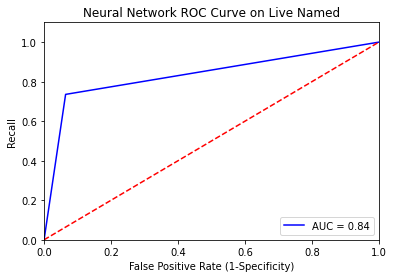

Train AUC: 0.830 vs Test AUC: 0.836


In [46]:
# Get the loss and accuracy on testing set
test_loss, test_acc = nn_model.evaluate(x_test_nn,  y_test, verbose=1) 
y_predicted = np.argmax(nn_model.predict(x_test_nn), axis=-1)


print('Test accuracy:', test_acc,' Test loss:', test_loss)
print_performance('Neural Network', y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NN_test = {}
NN_test['fpr'], NN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NN_train['auc'], NN_test['auc']))

In [47]:
nn_model.summary()

#history.history

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


# **Decision Tree**

This model uses GINI criterion to split the data and requires at least 10 observations to split and 5 observations in the leaf.

Confusion Matrix: 
 [[2161    0]
 [   0 2039]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2161
           1       1.00      1.00      1.00      2039

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200

AUC: 1.00


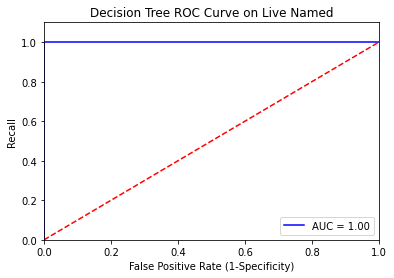

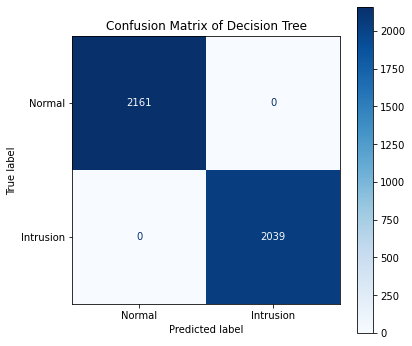

[[2161    0]
 [   0 2039]]
Train AUC: 1.000 vs Test AUC: 1.000


In [49]:
from sklearn.tree import DecisionTreeClassifier

# Create and Train DecTree model
decTree = DecisionTreeClassifier(criterion='gini', min_samples_split=10,min_samples_leaf=5,max_features='auto')
decTree = decTree.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = decTree.predict(x_train)
DT_train = {}
DT_train['fpr'], DT_train['tpr'], thresh = roc_curve(y_train, y_pred)
DT_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = decTree.predict(x_test)

# Print performance measures
print_performance('Decision Tree', y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Decision Tree', decTree, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
DT_test = {}
DT_test['fpr'], DT_test['tpr'], thresh = roc_curve(y_test, y_predicted)
DT_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(DT_train['auc'], DT_test['auc']))

# **Random Forest**

This model has no max depth and allows bootstrapping observations during training. It uses GINI criterion to split and requires a minimum of 10 observations to split and the leaf node must have above 5 observations.


Confusion Matrix: 
 [[2161    0]
 [   0 2039]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2161
           1       1.00      1.00      1.00      2039

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200

AUC: 1.00


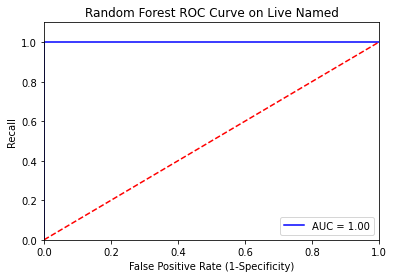

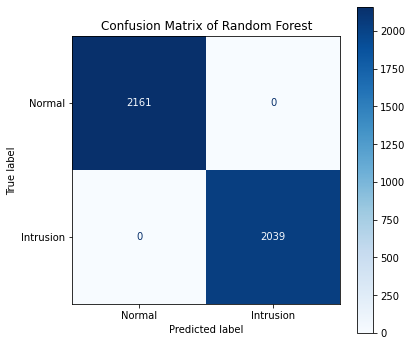

[[2161    0]
 [   0 2039]]
Train AUC: 1.000 vs Test AUC: 1.000


In [48]:
from sklearn.ensemble import RandomForestClassifier

# Build model
randomForest = RandomForestClassifier(max_depth=None, min_samples_split=10, min_samples_leaf=5, 
                                      max_features='auto', bootstrap=True,verbose=0, criterion='gini')
# Train the model with training set
randomForest.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = randomForest.predict(x_train)
RF_train = {}
RF_train['fpr'], RF_train['tpr'], thresh = roc_curve(y_train, y_pred)
RF_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict the labels for testing set
y_predicted = randomForest.predict(x_test)

# Print performance measures
print_performance('Random Forest', y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('Random Forest', randomForest, x_test, y_test, y_predicted)

# Recording TPR and FPR for the multi-ROC curves
RF_test = {}
RF_test['fpr'], RF_test['tpr'], thresh = roc_curve(y_test, y_predicted)
RF_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(RF_train['auc'], RF_test['auc']))

# **KNN**

This model classifies each observation based on 3 nearest neighbors with uniform weight.

Confusion Matrix: 
 [[2161    0]
 [   0 2039]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2161
           1       1.00      1.00      1.00      2039

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200

AUC: 1.00


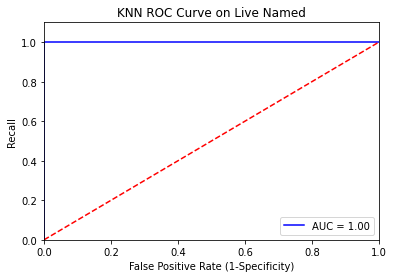

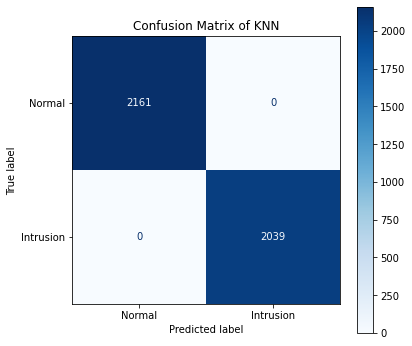

[[2161    0]
 [   0 2039]]
Train AUC: 1.000 vs Test AUC: 1.000


In [50]:
from sklearn.neighbors import KNeighborsClassifier

# Creat and Train KNN model
KNN = KNeighborsClassifier(n_neighbors=3, weights='uniform')
KNN.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = KNN.predict(x_train)
KNN_train = {}
KNN_train['fpr'], KNN_train['tpr'], thresh = roc_curve(y_train, y_pred)
KNN_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = KNN.predict(x_test)

# Print performance measures
print_performance('KNN', y_test, y_predicted)

# Color Confusion Matrix
color_confusion_matrix('KNN', KNN, x_test, y_test, y_predicted)

# Recording TPR and FPR for TESTING-ROC curves
KNN_test = {}
KNN_test['fpr'], KNN_test['tpr'], thresh = roc_curve(y_test, y_predicted)
KNN_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(KNN_train['auc'], KNN_test['auc']))

# **Naive Bayes**

Confusion Matrix: 
 [[2049  112]
 [ 385 1654]]

Testing Accuracy: 0.88
Precision:0.94
Recall: 0.81
False Positive Rate: 0.05

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2161
           1       0.94      0.81      0.87      2039

    accuracy                           0.88      4200
   macro avg       0.89      0.88      0.88      4200
weighted avg       0.89      0.88      0.88      4200

AUC: 0.88


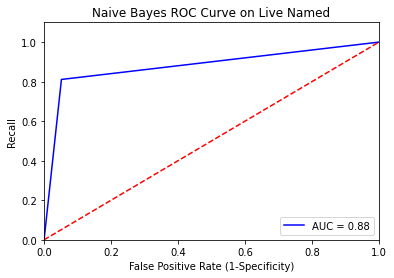

Train AUC: 0.874 vs Test AUC: 0.880


In [51]:
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes classifier and train with training set
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

# Recording TPR and FPR for the TRAINING ROC curves
y_pred = NaiveBayes.predict(x_train)
NB_train = {}
NB_train['fpr'], NB_train['tpr'], thresh = roc_curve(y_train, y_pred)
NB_train['auc'] = roc_auc_score(y_train, y_pred)

# Predict testing data
y_predicted = NaiveBayes.predict(x_test)

# Print performance measures
print_performance('Naive Bayes', y_test, y_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
NB_test = {}
NB_test['fpr'], NB_test['tpr'], thresh = roc_curve(y_test, y_predicted)
NB_test['auc'] = roc_auc_score(y_test, y_predicted)

print('Train AUC: %.3f vs Test AUC: %.3f' %(NB_train['auc'], NB_test['auc']))

# **Graphing multi-ROC Curves**

In [54]:
# Graphing overlaid ROC curves, where each one represents a model AUC score
def graph_multi_ROC ():
  # Set color for each model
  colors = {'KM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'NN': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'KM':'1--','LR': 'v--', 'SVM': '^--', 'NN': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))

  plt.plot(KM_test.get('fpr'), KM_test.get('tpr'), markers.get('KM'), color=colors.get('KM'),  label="KM - AUC=" + str(KM_test.get('auc').round(3)))
  plt.plot(LR_test.get('fpr'), LR_test.get('tpr'), markers.get('LR'), color=colors.get('LR'),  label="LR - AUC=" + str(LR_test.get('auc').round(3)))
  plt.plot(SVM_test.get('fpr'),SVM_test.get('tpr'),markers.get('SVM'),color=colors.get('SVM'), label="SVM - AUC="+ str(SVM_test.get('auc').round(3)))
  plt.plot(NN_test.get('fpr'), NN_test.get('tpr'), markers.get('NN'), color=colors.get('NN'),  label="NN - AUC=" + str(NN_test.get('auc').round(3)))
  plt.plot(DT_test.get('fpr'), DT_test.get('tpr'), markers.get('DT'), color=colors.get('DT'),  label="DT - AUC=" + str(DT_test.get('auc').round(3)))
  plt.plot(RF_test.get('fpr'), RF_test.get('tpr'), markers.get('RF'), color=colors.get('RF'),  label="RF - AUC=" + str(RF_test.get('auc').round(3)))
  plt.plot(KNN_test.get('fpr'),KNN_test.get('tpr'),markers.get('KNN'),color=colors.get('KNN'), label="KNN - AUC="+ str(KNN_test.get('auc').round(3)))
  plt.plot(NB_test.get('fpr'), NB_test.get('tpr'), markers.get('NB'), color=colors.get('NB'),  label="NB - AUC=" + str(NB_test.get('auc').round(3)))
  plt.plot(BERT_test.get('fpr'),BERT_test.get('tpr'), markers.get('BERT'), color=colors.get('BERT'),  label="BERT - AUC="+ str(BERT_test.get('auc').round(3)))
  plt.plot(GPT_test.get('fpr'),GPT_test.get('tpr'), markers.get('GPT'), color=colors.get('GPT'),  label="GPT-2 - AUC="+ str(GPT_test.get('auc').round(3)))

  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'Testing ROCs on ' + DATA)
  #plt.savefig(DATA_I+'-'+train_or_test+'.jpg', dpi = 80)
  plt.show()

# **BERT**


In [55]:
!pip install pytorch_pretrained_bert pytorch-nlp

     |████████████████████████████████| 133kB 17.5MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 133kB 37.2MB/s 
     |████████████████████████████████| 7.5MB 31.4MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
ERROR: botocore 1.20.68 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [56]:
from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

**Prepare for Train and test data for BERT**

In [57]:
train_texts = []
for i in range(x_train.shape[0]):
     train_texts.append(" ".join(np.array(x_train.iloc[i,:]).astype(str)))
train_texts = tuple(train_texts) 

test_texts = []
for i in range(x_test.shape[0]):
     test_texts.append(" ".join(np.array(x_test.iloc[i,:]).astype(str)))
test_texts = tuple(test_texts) 

train_labels = tuple(y_train.tolist())
test_labels = tuple(y_test.tolist())

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(9800, 9800, 4200, 4200)

In [58]:
# Tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Example
tokenizer.tokenize(train_texts[8])

100%|██████████| 231508/231508 [00:00<00:00, 18122035.95B/s]


['55', '45', '141', '107', '6', '107']

In [61]:
# Convert to tokens using tokenizer
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:20] + ['[SEP]'], test_texts))

print('Number of Training Sequences:',len(train_tokens), '\nNumber of Testing Sequences:', len(test_tokens) )       

Number of Training Sequences: 9800 
Number of Testing Sequences: 4200


In [62]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=20, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((9800, 20), (4200, 20))

In [63]:
# Prepare labels
# True if intrusion or False if normal
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((9800,), (4200,), 0.5062244897959184, 0.48547619047619045)

In [64]:
# To mask the paddings
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [65]:
# Define BERT model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        # First Layer
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)

        dropout_output = self.dropout(pooled_output)

        linear_output = self.linear(dropout_output)
        
        # output layer
        proba = self.sigmoid(linear_output)
        
        return proba
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).float()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      param_optimizer = list(self.sigmoid.named_parameters()) 
      optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.bert.parameters(), lr=2e-5)
      for epoch_num in range(epochs):
          self.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

              # Get the output of the model for provided input
              logits = self(token_ids, masks)
              
              # Loss function
              loss_func = nn.BCELoss()

              # Calculate Loss
              batch_loss = loss_func(logits, labels)
              train_loss += batch_loss.item()
              
              # backpropagate the error
              self.zero_grad()
              batch_loss.backward()
              
              # Update the Weights of the Model
              clip_grad_norm_(parameters=self.parameters(), max_norm=1.0)
              optimizer.step()
              
              clear_output(wait=True)
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))        

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [67]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

100%|██████████| 407873900/407873900 [00:07<00:00, 58189582.41B/s]


**Fine Tune BERT**

In [68]:
# Train BERT NLP
bert_clf.train_m(train_tokens_ids,train_y,train_masks,4,16)

Epoch:  4
612/612.5 loss: 8.108192419377459e-05 


**Evaluate on Testing Set**

In [69]:
# Convert token ids to tensor 
test_tokens_tensor = torch.tensor(test_tokens_ids)

# Convert labels to tensors
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

# Convert to tensro for maks
test_masks_tensor = torch.tensor(test_masks)


# Load Token, token mask and label into Dataloader
test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)

# Define sampler
test_sampler = SequentialSampler(test_dataset)

# Defile test data loader
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)

In [70]:
bert_clf.eval() # Define eval
bert_predicted = [] # To Store predicted result
all_logits = [] # Actual output that is between 0 to 1 is stored here

with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        # Load the batch on gpu memory
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # Calculate ouput of bert
        logits = bert_clf(token_ids, masks)

        # Get the numpy logits
        numpy_logits = logits.cpu().detach().numpy()  # Detach from the GPU memory
        
        # Using the threshold find binary 
        bert_predicted += list(numpy_logits[:, 0] > 0.5)  # Threshold conversion
        all_logits += list(numpy_logits[:, 0])

Confusion Matrix: 
 [[2161    0]
 [   0 2039]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2161
        True       1.00      1.00      1.00      2039

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200

AUC: 1.00


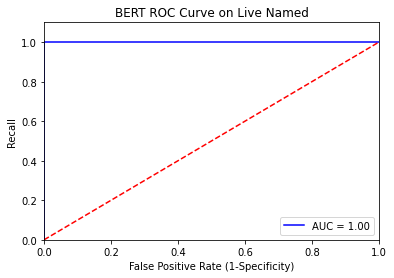

In [71]:
print_performance('BERT',test_y, bert_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
BERT_test = {}
BERT_test['fpr'], BERT_test['tpr'], thresh = roc_curve(test_y, bert_predicted)
BERT_test['auc'] = roc_auc_score(test_y, bert_predicted)

# **GPT-2**

In [72]:
!pip install transformers

from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

     |████████████████████████████████| 2.1MB 15.3MB/s 
     |████████████████████████████████| 3.3MB 53.8MB/s 
     |████████████████████████████████| 901kB 48.8MB/s 


In [73]:
tokenizer = GPT2Tokenizer.from_pretrained('microsoft/DialoGPT-small')

In [74]:
# Padding sequences from the right to a max length of 20
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token
train_tokens = tokenizer(train_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)
test_tokens = tokenizer(test_texts,return_tensors='pt',truncation=True,padding=True,max_length=20)

In [75]:
# Following is to convert List of words to list of numbers. (Words are replaced by their index in dictionar)

train_tokens_ids = train_tokens.input_ids
test_tokens_ids = test_tokens.input_ids

train_tokens_ids.shape, test_tokens_ids.shape

(torch.Size([9800, 6]), torch.Size([4200, 6]))

In [76]:
train_masks = train_tokens.attention_mask
test_masks = test_tokens.attention_mask

**Create GPT-2 Classifer**

In [77]:
class GTP2BinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(GTP2BinaryClassifier, self).__init__()
        self.gtp2 = GPT2ForSequenceClassification.from_pretrained('microsoft/DialoGPT-small')
      
    def train_m(self,x,y,train_mask,epochs,batchsize):
      train_tokens_tensor = torch.tensor(x)
      train_y_tensor = torch.tensor(y.reshape(-1, 1)).long()
      train_masks_tensor = torch.tensor(train_mask)

      train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
      train_sampler = RandomSampler(train_dataset)
      train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batchsize) 


      # param_optimizer = list(self.gtp2.parameters()) 
      # optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
      optimizer = Adam(self.gtp2.parameters(), lr=5e-5)
      for epoch_num in range(epochs):
          self.gtp2.train() # Training Flag
          train_loss = 0
          for step_num, batch_data in enumerate(train_dataloader):
              
              # Load batch on device memory
              token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
              self.zero_grad()

              # Get the output of the model for provided input
              outputs = self.gtp2(token_ids,attention_mask=masks,labels=labels)
              loss, logits = outputs[:2]
              # logits = self(token_ids, masks)
              
              # Total Loss
              train_loss += loss.item()
              
              # Backward pass the loss
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.gtp2.parameters(), 1.0)
              
              optimizer.step()
              logits = logits.detach().cpu().numpy()

              clear_output(wait=True)
        
              print('Epoch: ', epoch_num + 1)
              print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_labels) / batchsize, train_loss / (step_num + 1)))
        

In [78]:
gtp_clf = GTP2BinaryClassifier()
gtp_clf = gtp_clf.cuda()

Some weights of the model checkpoint at microsoft/DialoGPT-small were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-small and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
# Configure the Padding token id
gtp_clf.gtp2.config.pad_token_id = tokenizer.eos_token_id
gtp_clf.train_m(train_tokens_ids,train_y,train_masks,4,16)

Epoch:  4
612/612.5 loss: 0.0019523643989480398 


**Evaluate on Testing Set**

In [80]:
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).long()

test_masks_tensor = torch.tensor(test_masks)


test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=16)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [81]:
# Evaluate Model
gtp_clf.eval() # Define eval
gpt_predicted = [] # Store Result
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        # ----------------------------------------------------------------
        outputs = gtp_clf.gtp2(token_ids,attention_mask=masks,labels=labels)
        loss, logits = outputs[:2]
        numpy_logits = logits.detach().cpu().numpy()
        # ----------------------------------------------------------------
        gpt_predicted +=list(numpy_logits.argmax(axis=-1).flatten().tolist())

Confusion Matrix: 
 [[2161    0]
 [   0 2039]]

Testing Accuracy: 1.00
Precision:1.00
Recall: 1.00
False Positive Rate: 0.00

Classification report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2161
        True       1.00      1.00      1.00      2039

    accuracy                           1.00      4200
   macro avg       1.00      1.00      1.00      4200
weighted avg       1.00      1.00      1.00      4200

AUC: 1.00


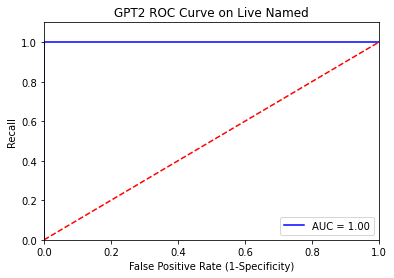

In [82]:
print_performance('GPT2',test_y, gpt_predicted)

# Recording TPR and FPR for the TESTING-ROC curves
GPT_test = {}
GPT_test['fpr'], GPT_test['tpr'], thresh = roc_curve(test_y, gpt_predicted)
GPT_test['auc'] = roc_auc_score(test_y, gpt_predicted) 

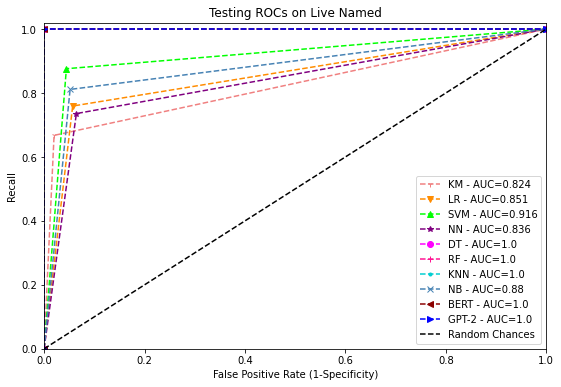

In [83]:
# Ploting the overlaid ROC curves on testing results:
graph_multi_ROC()

## **End**